# Introduction

In this project, our aim is to study how present the world's universities are in Google's search results, and use the results to build an alternative university ranking.
We will then compare our results to more traditionnal university rankings to see how much information we are able to extract simply by looking at Google search results.

The methodology used is as follows:
We have a list of the world's universities and a list of Google search queries (of the form <degree_type> + <subject>, e.g. "master's in computer science")
We make a request to Google for each of our search queries, and we parse the results page to extract all the universities that appear for a given search queries, as well as the order they appear in.
To build the simplest version of our ranking, we then count how many times each universities appear when we aggregate over all keywords, and we ponder the results with the order the universities appear in (i.e. if for "master's in computer science, EPFL appears 10th and ETHZ appears 25th on the search results page, then we give more weight to EPFL than ETHZ).

We then take things a step further by using data drawn from Google Keyword Planner to ponder the different search queries used. For each search query, we have access to data such as the monthly search volume, the competition when advertising on this keyword, as well as the suggested bid when advertising on that keyword. We consider as search query to be more important when the three values are higher.

We also study our results on a country by country basis. This allows us to see which countries are the most represented. However, we recognise that our methodology has its limitation because all of our search queries are in English, and not all universities have an English version of their website.

Finally we compare our results to those obtained in more traditionnal university rankings.


In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading data

In [9]:
keywords = pd.read_csv('keywords/rankfalcon_exports/keywords.csv')
sites = pd.read_csv('keywords/rankfalcon_exports/sites.csv')
rankings = pd.read_csv('keywords/rankfalcon_exports/rankings.csv')
universities = pd.read_csv('universities/university_list_countries.csv')
keyword_data = pd.read_csv('keywords/Keyword Planner type 1 2017-01-09 at 01-28-48.csv', sep='\t')

rankings = rankings.merge(keywords, on='id_keyword')
rankings = rankings.merge(sites, on='id_site')
rankings = rankings.merge(universities, left_on='domain', right_on='Website')
rankings = rankings[['rank','keyword', 'domain', 'University', 'Country']]
rankings = rankings.drop_duplicates()  # Note the data is dirty and contains about 10000 duplicates
rankings.head()

,rank,keyword,domain,University,Country
0,43,bachelor's degree in Economics,www.au.dk,Aarhus University,Denmark
1,42,bachelor's degree in Economics,www.au.dk,Aarhus University,Denmark
2,91,bachelor's degree in English Language,www.au.dk,Aarhus University,Denmark
3,29,bachelor's degree in Archaeology,www.au.dk,Aarhus University,Denmark
4,7,bachelor's degree in Business & Commercial Law,www.au.dk,Aarhus University,Denmark


We have used a list of over 300 search queries (of the form <degree_type> + <subject>, e.g. "master's in computer science") and a list of about 10000 universities across the world. 

Each entry in the above table represents an appeareance of the given university domain amoung the first 100 Google search results obtained with the corresponding query (keyword). The rank is the position the university appeared on the results page.



# Initial data exploration

In [10]:
rankings.domain.describe()

count           24488
unique           1447
top       www.asu.edu
freq              223
Name: domain, dtype: object

In [11]:
sites.count()

id_site    9260
domain     9258
dtype: int64

We see that 1448 / 9260 of the universities considered appear at least once in the google search results. Seen under a different light, this means that 7812 universities are hardly visible on the web...

## Very basic ranking of universities

We can see which universities are the most present in Google search results simply by seeing on how many queries they appear (see following table). In the following sections, we will precede to ponder our results with the search rankings and with keyword metadata.

With unweighted results we see the ase.edu (Arizona state university) appears the most (for 223 keywords out of a possible 339)

In [12]:
rankings.University.value_counts().head()

Arizona State University         223
Boston University                209
New York University              194
Stanford University              180
Pennsylvania State University    174
Name: University, dtype: int64

In [13]:
rankings.University.value_counts().to_csv('keywords/rankfalcon_exports/unweighted_ranking.csv')

# Pondering the results with search rankings

The search rank corresponds to the position a given website appears on the search results page for a given query. For example, if for the query "master's in computer science", EPFL appears in first position and ETHZ in second, then we say that EPFL's search ranking is 1 and ETHZ's is 2.

To use the ranking data, we invert the rank obtained because a higher rank is better (i.e. ranking first is better than ranking 99th). We need to make sure this is reflected in the weighting.

We then weight our rankings depending on where the university came in the the search results for each query. We call the new rank "inv_rank" (see table below)

In [14]:
rankings['inv_rank'] = rankings['rank'].apply(lambda x: 1./x)
rankings.head()

,rank,keyword,domain,University,Country,inv_rank
0,43,bachelor's degree in Economics,www.au.dk,Aarhus University,Denmark,0.023256
1,42,bachelor's degree in Economics,www.au.dk,Aarhus University,Denmark,0.023810
2,91,bachelor's degree in English Language,www.au.dk,Aarhus University,Denmark,0.010989
3,29,bachelor's degree in Archaeology,www.au.dk,Aarhus University,Denmark,0.034483
4,7,bachelor's degree in Business & Commercial Law,www.au.dk,Aarhus University,Denmark,0.142857


# Grouping by university

The next step is naturally to group our results by university. This basically comes down to taking the sum of all the "inv_rank"s over all the search queries on which a university appears. See the table below for a ranking of universities taking into account search rankings.

In [15]:
grouped_rankings = rankings.groupby(['University','Country'])

In [16]:
grouped_weighted_rankings = grouped_rankings.sum().sort_values(['inv_rank'], ascending=False)
grouped_weighted_rankings.head()

,,rank,inv_rank
University,Country,,
Boston University,USA,7547,25.329307
New York University,USA,7445,15.952792
Stanford University,USA,6479,15.136372
Southern New Hampshire University,USA,2788,14.145092
Columbia University,USA,4861,14.031654


Above is a weighted ranking of the universities

In [17]:
grouped_weighted_rankings.to_csv('keywords/rankfalcon_exports/weighted_rankings.csv', encoding='utf-8')

# Country by country ranking

We may also be interested in seeing how represented each countries are in our alternative rankings. See table below which shows the number of universities of each country present in the ranking.

In [18]:
weighted_rankings = pd.read_csv('keywords/rankfalcon_exports/weighted_rankings.csv', encoding='utf-8')

In [19]:
# Our data source for countries specifies individuals states. We replace these states with "United States of America"
states = ['New York', 'California', 'Pennsylvania', 'Texas', 'Massachusetts','Illinois','Ohio','Florida','Virginia','Michigan','North Carolina',
         'Tennessee','Indiana','Wisconsin','Georgia','Missouri','Minnesota','Colorado','New Jersey','Alabama','Louisiana','Washington',
         'Maryland','Oregon','Kentucky','Connecticut','Kansas','Nebraska','Oklahoma','South Carolina','Maine','Vermont','Mississippi',
         'Rhode Island','Arizona','Arkansas','District of Columbia','Iowa','Utah','New Hampshire','South Dakota','Idaho','New Mexico',
         'Delaware','Alaska','Hawaii', 'North Dakota', 'Wyoming','Montana','Nevada','West Virginia']
weighted_rankings['Country'].replace(to_replace=states,value='United States of America').value_counts().head(20)

USA               896
United Kingdom     93
Canada             55
Germany            40
Australia          33
Italy              30
Spain              20
France             17
China              14
Netherlands        14
Sweden             13
Malaysia           12
South Africa       12
India              12
Ireland            11
Pakistan           11
Japan               9
Finland             9
Norway              8
Austria             8
Name: Country, dtype: int64

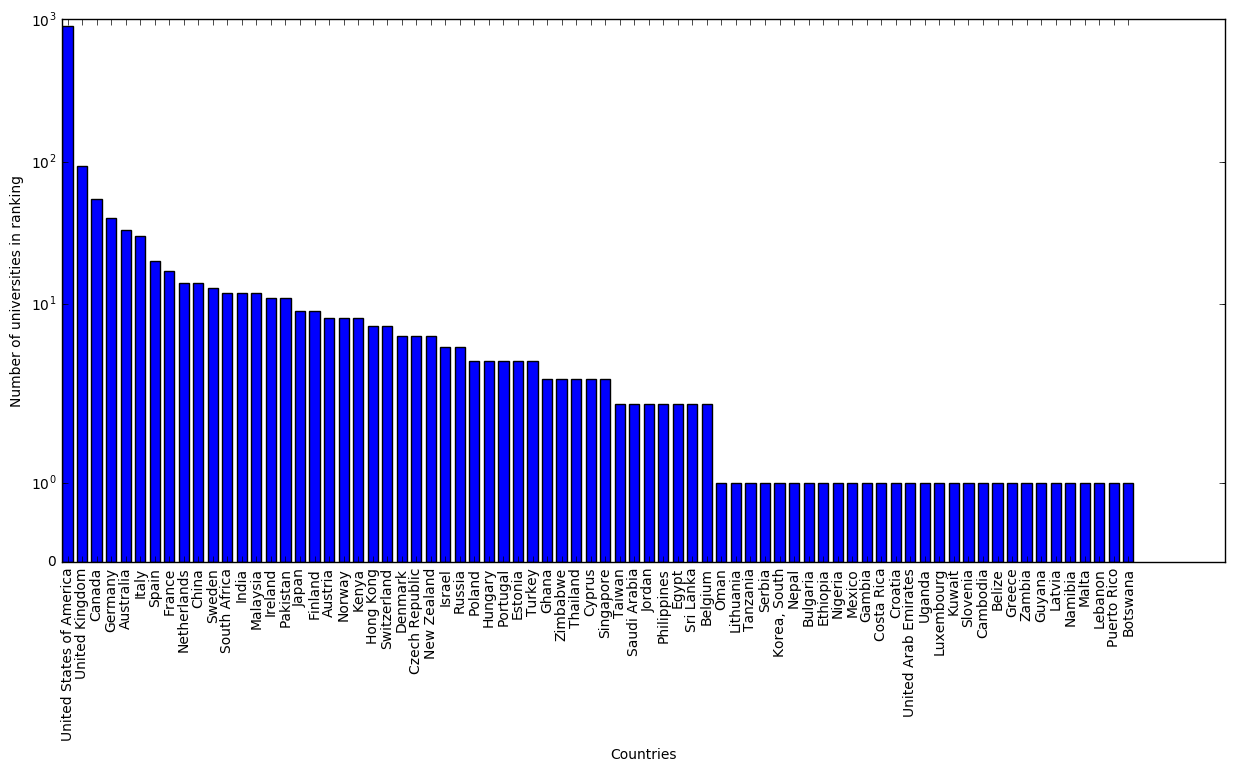

In [57]:
country_data = weighted_rankings['Country'].replace(to_replace=states,value='United States of America').value_counts()
figure_countries = plt.figure(figsize=(15,7))
plt.bar(np.arange(country_data.shape[0]),country_data, 0.7)
plt.xlabel('Countries')
plt.ylabel('Number of universities in ranking')
x = plt.xticks(np.arange(country_data.shape[0]) + 0.7 / 2, country_data.keys(), rotation='vertical')
plt.yscale('symlog')

In [20]:
weighted_rankings.replace(to_replace=states,value='United States of America').groupby('Country').size().shape

(74,)

First observation: 74 countries make it onto our rankings.

Second observation: Heavy dominance by US then english speaking countries.

Up to here, all the queries have been made in English, so it's not surprising that the results are dominated by English speaking countries. Nevertheless many non native English universities often have websites in English, allowing them to rank. We might make adjustment in the future to balance out the playing field. However, we should note that other university rankings are heavily dominated by English speaking universities too.

# Pondering with keyword metadata

In this section, we aim to weight the different search queries (degree type + subject) according to data drawn from Google keyword  planner consisting of search volume, competition and suggested bid.

- Search volume: we suppose that keywords with higher search volumes are more important
- Competition: we suppose that more competitive keywords (when bidding for ads) are more important
- Suggested bid: we suppose that a higher suggested bid (for placing an ad on this keyword) indicates a more important keyword.

In [21]:
# auxiliary function
def lower(string):
    return string.lower()

In [22]:
# data wrangling
rankings.columns = ['rank', 'Keyword', 'domain', 'University', 'Country', 'inv_rank']
rankings['Keyword'] = rankings['Keyword'].apply(lower)

In [23]:
# loading and cleaning the keyword data
keyword_data = pd.read_csv('keywords/Keyword Planner type 1 2017-01-09 at 01-28-48.csv', sep='\t')

# data cleaning
keyword_data.columns = ['Keyword', 'Search volume','Competition', 'Suggested bid']
keyword_data['Search volume'].fillna(1, inplace=True)
keyword_data['Competition'].fillna(0.1, inplace=True)
keyword_data['Suggested bid'].fillna(0.01, inplace=True)

# Search volume mapping
keyword_data['Search volume'].unique()
keyword_data['Search volume'].replace(['1K – 10K', '100 – 1K', '10 – 100', '0'],[3,4,2,1], inplace=True)
keyword_data.head()

,Keyword,Search volume,Competition,Suggested bid
0,phd in management,3,0.29,3.62
1,phd in psychology,3,0.55,24.62
2,phd in economics,3,0.15,2.70
3,phd in germany,3,0.26,0.98
4,phd in law,3,0.18,3.28


The plots below show the distributions of the keyword (search query) metadata. Unfortunately, no data was available for about half of the keywords (too little search volume in general), giving us a slightly skewed distribution.

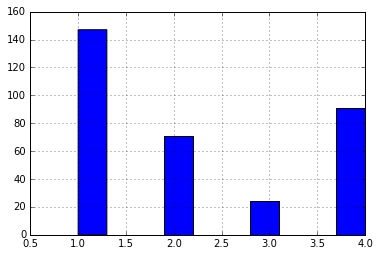

In [24]:
# Plotting the distribution of values
keyword_data['Search volume'].hist()

We notice that the values for competition and suggested bid are not that well distributed, that is to say the largest values are much larger than the smallest ones. When we weight with these values it will very strongly skewer the rankings obtained in favour of competitive keywords. We don't want the metadata to have so much of an effect. Therefore we normalise the values, scaling them to be between 1 and 2, so that the largest value is only 2 times bigger than the smallest one.

Axes(0.125,0.125;0.775x0.775)


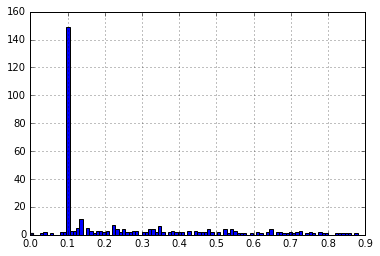

In [25]:
print(keyword_data['Competition'].hist(bins=100))

Axes(0.125,0.125;0.775x0.775)


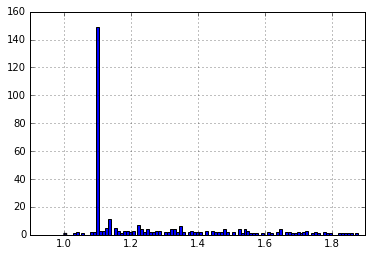

In [26]:
import math
print(keyword_data['Competition'].apply(lambda x: x+1).hist(bins=100))

Axes(0.125,0.125;0.775x0.775)


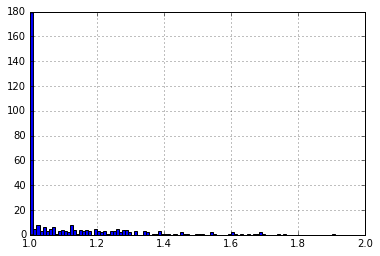

In [27]:
print(keyword_data['Suggested bid'].apply(lambda x: x/50 +1).hist(bins=100))

Having cleaned the keyword metadata, we now procede to weight the rankings with the new data. We take the previous ranking "inv_rank" and multiply it with our new data to weight each ranking. We call the new column "weighted_in_rank".

In [28]:
# weighting the rankings with keyword data
coef_search_volume = 1
coef_competition = 10
coef_suggested_bid = 10
rankings_seo_data = rankings.merge(keyword_data, on='Keyword')
rankings_seo_data['weighted_inv_rank']=rankings_seo_data['inv_rank']*coef_search_volume*rankings_seo_data['Search volume']*coef_competition*rankings_seo_data['Competition'].apply(lambda x:x+1)*coef_suggested_bid*rankings_seo_data['Suggested bid'].apply(lambda x: x/50+1)
# print(rankings_seo_data['weighted_inv_rank'].describe())
rankings_seo_data.head()

,rank,Keyword,domain,University,Country,inv_rank,Search volume,Competition,Suggested bid,weighted_inv_rank
0,43,bachelor's degree in economics,www.au.dk,Aarhus University,Denmark,0.023256,4,0.17,3.56,11.658642
1,42,bachelor's degree in economics,www.au.dk,Aarhus University,Denmark,0.023810,4,0.17,3.56,11.936229
2,75,bachelor's degree in economics,www.anu.edu.au,Australian National University,Australia,0.013333,4,0.17,3.56,6.684288
3,62,bachelor's degree in economics,www.concordia.ca,Concordia University,Canada,0.016129,4,0.17,3.56,8.085832
4,61,bachelor's degree in economics,www.concordia.ca,Concordia University,Canada,0.016393,4,0.17,3.56,8.218387


In [42]:
# get lat/lon data
lat_lon = pd.read_csv('universities/University_locations.csv', encoding='utf-8' )
lat_lon.head()

,Unnamed: 0,Country,University,Website,lat,lng
0,0,Afghanistan,Afghan University,www.afghanuniversity.edu.af,34.475522,69.126454
1,1,Afghanistan,Al-Birony University,www.au.edu.af,35.126848,69.317578
2,2,Afghanistan,American University of Afghanistan,www.auaf.edu.af,34.475522,69.126454
3,3,Afghanistan,Aria Institute of Higher Education,www.aria.edu.af,27.030823,75.893719
4,4,Afghanistan,Ariana Institute of Higher Education,www.ariana.edu.af,30.310454,-97.859309


In [43]:
# export to json
def extract_degree_type(keyword):
    if keyword[0]=='b':
        return 'bachelor'
    elif keyword[0]=='m':
        return 'master'
    else:
        return 'phd'
def extract_subject(keyword):
    return keyword.split('in ')[1]



rankings_seo_data_json = rankings_seo_data.copy()
rankings_seo_data_json['degree_type'] = rankings_seo_data_json['Keyword'].apply(extract_degree_type)
rankings_seo_data_json['subject'] = rankings_seo_data_json['Keyword'].apply(extract_subject)
rankings_seo_data_json['Country'].replace(to_replace=states,value='United States', inplace=True)
rankings_seo_data_json = rankings_seo_data_json.merge(lat_lon[['University','lat','lng']], on='University')
rankings_seo_data_json[['domain', 'University', 'Country', 'weighted_inv_rank', 'degree_type', 'subject','lat','lng']].to_csv('website/data/data.csv')
rankings_seo_data_json.head()

,rank,Keyword,domain,University,Country,inv_rank,Search volume,Competition,Suggested bid,weighted_inv_rank,count,degree_type,subject,lat,lng
0,43,bachelor's degree in economics,www.au.dk,Aarhus University,Denmark,0.023256,4,0.17,3.56,11.658642,1,bachelor,economics,56.168138,10.203012
1,42,bachelor's degree in economics,www.au.dk,Aarhus University,Denmark,0.023810,4,0.17,3.56,11.936229,1,bachelor,economics,56.168138,10.203012
2,91,bachelor's degree in english language,www.au.dk,Aarhus University,Denmark,0.010989,2,0.11,0.01,2.440048,1,bachelor,english language,56.168138,10.203012
3,29,bachelor's degree in archaeology,www.au.dk,Aarhus University,Denmark,0.034483,2,0.27,0.01,8.760372,1,bachelor,archaeology,56.168138,10.203012
4,80,bachelor's degree in spanish,www.au.dk,Aarhus University,Denmark,0.012500,3,0.20,20.79,6.371100,1,bachelor,spanish,56.168138,10.203012


# Ranking with keyword metadata weighting

In [30]:
#calculating the new keyword ranking
rankings_seo_data['count']=1
rankings_seo_data_grouped = rankings_seo_data.groupby(['University','Country']).sum().sort_values(['weighted_inv_rank'], ascending=False)
rankings_seo_data_grouped.head()

,,rank,inv_rank,Search volume,Competition,Suggested bid,weighted_inv_rank,count
University,Country,,,,,,,
Boston University,USA,2440,14.034576,248,23.06,701.96,6100.751422,79
Southern New Hampshire University,USA,424,6.794156,81,14.56,445.16,3626.403619,27
Stanford University,USA,2634,7.536873,237,19.75,393.60,3383.680806,75
New York University,USA,2397,6.833305,220,21.16,541.68,3115.857911,70
George Mason University,USA,1812,5.864796,157,15.98,406.44,2978.001996,49


# Effect of weighting by keyword metadata

We would like to see how much effect on the rankings our weighted procedures have. To do this, we produce a table where we show the ranking of each university under each of the three different methodology we have used so far. 

To recap the first (count) was simply counting the net number of appearances of a university over all keywords, the second (inv_rank) was pondering with search rankings, and the third (weighted_inv_rank) is pondering with search rankings and with keyword metadata.

We also calculate the difference between weighted_inv_rank and inv_rank to see how much the rankings change by.

In [31]:
ranking_comp_table = rankings_seo_data_grouped.copy()
ranking_comp_table['weighted_inv_rank'] = ranking_comp_table['weighted_inv_rank'].rank(ascending=False)
ranking_comp_table['inv_rank'] = ranking_comp_table['inv_rank'].rank(ascending=False)
ranking_comp_table['count'] = ranking_comp_table['count'].rank(ascending=False)
ranking_comp_table['diff'] = ranking_comp_table['weighted_inv_rank'] - ranking_comp_table['inv_rank']
ranking_comp_table.sort_values('weighted_inv_rank')[['count','inv_rank','weighted_inv_rank','diff']].head()

,,count,inv_rank,weighted_inv_rank,diff
University,Country,,,,
Boston University,USA,1.0,1.0,1.0,0.0
Southern New Hampshire University,USA,85.5,4.0,2.0,-2.0
Stanford University,USA,3.0,2.0,3.0,1.0
New York University,USA,4.0,3.0,4.0,1.0
George Mason University,USA,18.5,8.0,5.0,-3.0


See graph below for the distribution of "diff", i.e. how much the rankings change when we ponder using the keyword meta data.

The majority of unversities are not much affected (diff = 0 approx), but we do notice that they are still are sizeable chunk of universities whose rankings vary quite a lot.

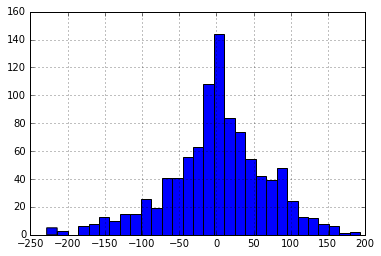

In [32]:
ranking_comp_table.sort_values('weighted_inv_rank')['diff'].hist(bins=30)

# Comparaison with traditional rankings

We have chosen to compare our results with the Shanghai world university ranking. We made this choice because it is a well known ranking that offers the domain name of the universities in their rankings which made it easy to compare.

First we load both rankings and manually adjusted some keys (domain). Then we merge our ranking together with the shanghai ranking.

In [33]:
df_sha_rankings = pd.read_csv("sha_rankings.csv", names=['rank_sha','University','sha_url','domain'], skiprows=1)
df_sha_rankings.loc[4,'domain'] = 'www.mit.edu'
df_sha_rankings.loc[21,'domain'] = 'www.ic.ac.uk'
df_sha_rankings.loc[25, 'domain'] = 'www.nwu.edu'
df_sha_rankings.loc[30, 'domain'] = 'www.uillinois.edu'
df_sha_rankings.loc[32, 'domain'] = 'www1.umn.edu'
df_sha_rankings.loc[34, 'domain'] = 'www.man.ac.uk'
df_sha_rankings.loc[38, 'domain'] = 'www.jussieu.fr'
df_sha_rankings.loc[42, 'domain'] = 'www.utsouthwestern.edu'
df_sha_rankings.loc[47, 'domain'] = 'www.tu-muenchen.de'
df_sha_rankings.loc[50, 'domain'] = 'www.fh-muenchen.de'
df_sha_rankings.loc[53, 'domain'] = 'www.unizh.ch'
df_sha_rankings.loc[55, 'domain'] = 'www.helsinki.fi'
df_sha_rankings.loc[56, 'domain'] = 'www.bris.ac.uk'
df_sha_rankings.loc[61, 'domain'] = 'www.rug.ac.be'
df_sha_rankings.loc[79, 'domain'] = 'www.ohio-state.edu'
df_sha_rankings.loc[81, 'domain'] = 'www.usyd.edu.au'
df_sha_rankings.loc[93, 'domain'] = 'www.kuleuven.ac.be'
df_sha_rankings.loc[94, 'domain'] = 'www.leidenuniv.nl'
df_sha_rankings.loc[96, 'domain'] = 'www.rutgers.edu'
sha_wur_comp = pd.merge(df_sha_rankings, universities, left_on='domain', right_on='Website', how='left')[['rank_sha', 'University_x', 'University_y','domain', 'Website']]

In [34]:
# shanghai ranking (rank, university)
sha_comp = sha_wur_comp[['rank_sha', 'University_y']]
sha_comp.columns = ['rank_sha', 'University']

In [35]:
# our ranking (rank, university)
wur_rankings = pd.DataFrame(ranking_comp_table.sort_values('weighted_inv_rank')['weighted_inv_rank'].reset_index()[0:100])
wur_rankings = wur_rankings[['University', 'weighted_inv_rank']]
wur_rankings.columns = ['University', 'rank_wur']

In [36]:
# combined
sha_wur_comp = pd.merge(sha_comp, wur_rankings,how='outer')

The merges creates NaN values because we only consider the first 100 universities in both rankings and these do not overlap completely. There are 44 universities that appear both in our ranking as in the shanghai ranking.

In [47]:
print('The overlap between the two rankings contains {} universities'.format(100 - sha_wur_comp['rank_wur'].isnull().sum()))

The overlap between the two rankings contains 44 universities


In [60]:
comparison_result = sha_wur_comp.loc[np.where((sha_wur_comp['rank_sha'].notnull()) & (sha_wur_comp['rank_wur'].notnull()))].sort_values('rank_wur')
comparison_result['rank_sha'] = comparison_result['rank_sha'] + 1
comparison_result['diff'] = comparison_result['rank_sha'] - comparison_result['rank_wur']
comparison_result['direction'] = (comparison_result['diff'] > 0)*1

Analysis:

1. The entire top 5 of the Shanghai ranking is present in our ranking, where the University of California and Stanford University even appear in the top 5.

2. Two universities in our top 5 are not represented in the top 100 Shanghai: Southern New Hampshire University	(2) and George Mason University	(5).

3. Boston University (our number 1) increases 74 positions.

In [62]:
comparison_result.head()

,rank_sha,University,rank_wur,diff,direction
74,75.0,Boston University,1.0,74.0,1
1,2.0,Stanford University,3.0,-1.0,0
28,29.0,New York University,4.0,25.0,1
2,3.0,"University of California, Berkeley",6.0,-3.0,0
3,4.0,University of Cambridge,8.0,-4.0,0


In [65]:
comparison_result.sort_values('rank_sha').head()

,rank_sha,University,rank_wur,diff,direction
0,1.0,Harvard University,12.0,-11.0,0
1,2.0,Stanford University,3.0,-1.0,0
2,3.0,"University of California, Berkeley",6.0,-3.0,0
3,4.0,University of Cambridge,8.0,-4.0,0
4,5.0,Massachusetts Institute of Technology,45.0,-40.0,0


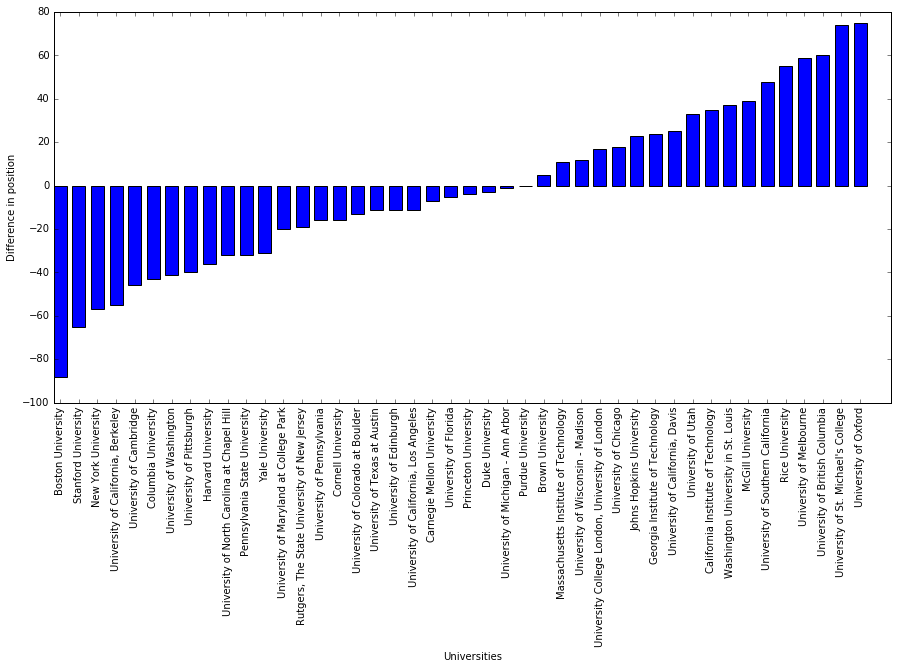

In [96]:
figure = plt.figure(figsize=(15,7))
plt.bar(np.arange(comparison_result.shape[0]),comparison_result['diff'].sort_values(), 0.7)
plt.xlabel('Universities')
plt.ylabel('Difference in position')
x = plt.xticks(np.arange(comparison_result.shape[0]) + 0.7 / 2, comparison_result['University'], rotation='vertical')